In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## RSNA Screening Mammography Breast Cancer Detection
### Find breast cancers in screening mammograms

### Overview
* In this notebook we will see how to convert the DICOM images to PNG images and how to create the ROIs (Regions of Interest) for the images.

* A Region of Interest (ROI) is a part of an image that is of interest and requires special attention. The concept of a ROI is commonly used in many application areas.  For example, in medical imaging, the boundaries of a tumor may be defined on an image or in a volume, for the purpose of measuring its size. In geographical information systems (GIS), a ROI can be taken literally as a polygonal selection from a 2D map. In computer vision and optical character recognition, the ROI defines the borders of an object under consideration. In image processing, the ROI is a rectangular subset of an image that is used to perform a specific operation. 

* So, in this notebook we will create the ROIs for the images in order to improves the recognition of the breast cancer. In fact, observing the images we can see that the breast cancer occupies a small part of the image, so we can create a ROI in order to focus the attention of the model on the part of the image that contains the breast cancer.

### Outline
* [1. Install libraries](#1)
* [2. Import libraries](#2)
* [3. Configuration](#3)
* [4. Load data](#4)
* [5. Assing input and output paths](#5)
* [6. Utility functions](#6)
* [7. Create ROIs](#7)
* [8. Results](#8)
* [9. Additional resources](#9)

### 1. Install libraries <a id="1"></a>

In [2]:
from IPython.display import clear_output

In [1]:
!pip -q install dicomsdl
#clear_output()

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


### 2. Import libraries <a id="2"></a>

In [14]:
import os, random, dicomsdl
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

### 3. Configuration <a id="3"></a>

In [4]:
img_size = [1024, 512]
resize_dim = [(1024,512), (512,256)]

class Config:
    def __init__(self):

        self.path = '/kaggle/input/rsna-breast-cancer-detection/'
        self.train_path = self.path + 'train_images/'
        self.test_path = self.path + 'test_images/'
        self.train_csv = self.path + 'train.csv'
        self.test_csv = self.path + 'test.csv'
        
        self.output_path = '/kaggle/working/'
        self.train_output_path = self.output_path + 'train_images/'
        self.test_output_path = self.output_path + 'test_images/'

        self.img_size = img_size[0]
        self.resize_dim = resize_dim[0]

config = Config()

### 4. Load data <a id="4"></a>

In [5]:
train_df = pd.read_csv(config.train_csv)
test_df = pd.read_csv(config.test_csv)

In [6]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


### 5. Assign the input and output paths <a id="5"></a>

In [7]:
train_df['dicom_path'] = config.train_path + train_df['patient_id'].astype(str) + '/' + train_df['image_id'].astype(str) + '.dcm'
train_df['image_path'] = config.train_output_path + train_df['patient_id'].astype(str) + '/' + train_df['image_id'].astype(str) + '.png'

test_df['dicom_path'] = config.test_path + test_df['patient_id'].astype(str) + '/' + test_df['image_id'].astype(str) + '.dcm'
test_df['image_path'] = config.test_output_path + test_df['patient_id'].astype(str) + '/' + test_df['image_id'].astype(str) + '.png'

In [8]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,dicom_path,image_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10011/220375232.png


In [9]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,dicom_path,image_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,/kaggle/working/test_images/10008/736471439.png
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,/kaggle/working/test_images/10008/1591370361.png
2,2,10008,68070693,R,MLO,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...,/kaggle/working/test_images/10008/68070693.png
3,2,10008,361203119,R,CC,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...,/kaggle/working/test_images/10008/361203119.png


### 6. Utility functions <a id="6"></a>

In [10]:
def dicom_to_png(dicom_path):
    dicom = dicomsdl.open(dicom_path)
    image = dicom.pixelData(storedvalue=False)
    image = image - np.min(image)
    image = image / np.max(image)

    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        image = 1.0 - image
    
    image = cv2.resize(image, (config.img_size, config.img_size), interpolation=cv2.INTER_LINEAR)
    image = (image * 255).astype(np.uint8)
    return image

In [11]:
def png_to_roi(image, image_path):
    bin_image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    roi = image[np.min(xs):np.max(xs), np.min(ys):np.max(ys)]
    return cv2.resize(roi, config.resize_dim[::-1], interpolation=cv2.INTER_LINEAR)

### 7. Create ROIs <a id="7"></a>

In [12]:
def process(dicom_path, image_path):
    image = dicom_to_png(dicom_path)
    os.makedirs(os.path.dirname(image_path), exist_ok=True)
    image = png_to_roi(image, image_path)
    cv2.imwrite(image_path, image)

In [15]:
Parallel(n_jobs=4, backend='threading')(delayed(process)(dicom_path, image_path) 
                   for dicom_path, image_path in tqdm(zip(train_df['dicom_path'], 
                                                          train_df['image_path'])))


0it [00:00, ?it/s]
8it [00:05,  1.42it/s]
12it [00:09,  2.16it/s]
13it [00:09,  1.16it/s]
16it [00:11,  1.27it/s]
20it [00:12,  1.88it/s]
24it [00:13,  2.38it/s]
28it [00:19,  1.47it/s]
29it [00:19,  1.37it/s]
32it [00:20,  1.62it/s]
33it [00:20,  1.76it/s]
36it [00:24,  2.13it/s]
37it [00:24,  1.21it/s]
40it [00:29,  1.04it/s]
41it [00:29,  1.15s/it]
44it [00:33,  1.12s/it]
45it [00:33,  1.07s/it]
48it [00:36,  1.05it/s]
52it [00:37,  1.52it/s]
53it [00:37,  1.61it/s]
56it [00:39,  1.86it/s]
57it [00:39,  1.96it/s]
60it [00:41,  1.90it/s]
61it [00:41,  2.09it/s]
64it [00:42,  2.15it/s]
65it [00:42,  2.34it/s]
68it [00:45,  2.00it/s]
69it [00:45,  2.01it/s]
72it [00:52,  1.24it/s]
73it [00:52,  1.20s/it]
76it [00:53,  1.19it/s]
77it [00:53,  1.39it/s]
80it [00:59,  1.08s/it]
81it [00:59,  1.15s/it]
84it [01:07,  1.54s/it]
85it [01:07,  1.54s/it]
88it [01:11,  1.37s/it]
89it [01:11,  1.27s/it]
92it [01:14,  1.13s/it]
93it [01:14,  1.03it/s]
96it [01:16,  1.29it/s]
97it [01:16,  1.46it/

KeyboardInterrupt: 

In [16]:
Parallel(n_jobs=4, backend='threading')(delayed(process)(dicom_path, image_path) 
                   for dicom_path, image_path in tqdm(zip(test_df['dicom_path'], 
                                                          test_df['image_path'])))
clear_output()

### 8. Results <a id="8"></a>

In [17]:
def plot_images(images, titles, rows=2, cols=5, figsize=(20, 15)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.25)
    for ax, im, title in zip(grid, images, titles):
        ax.imshow(im)
        ax.set_title(title)
    plt.show()

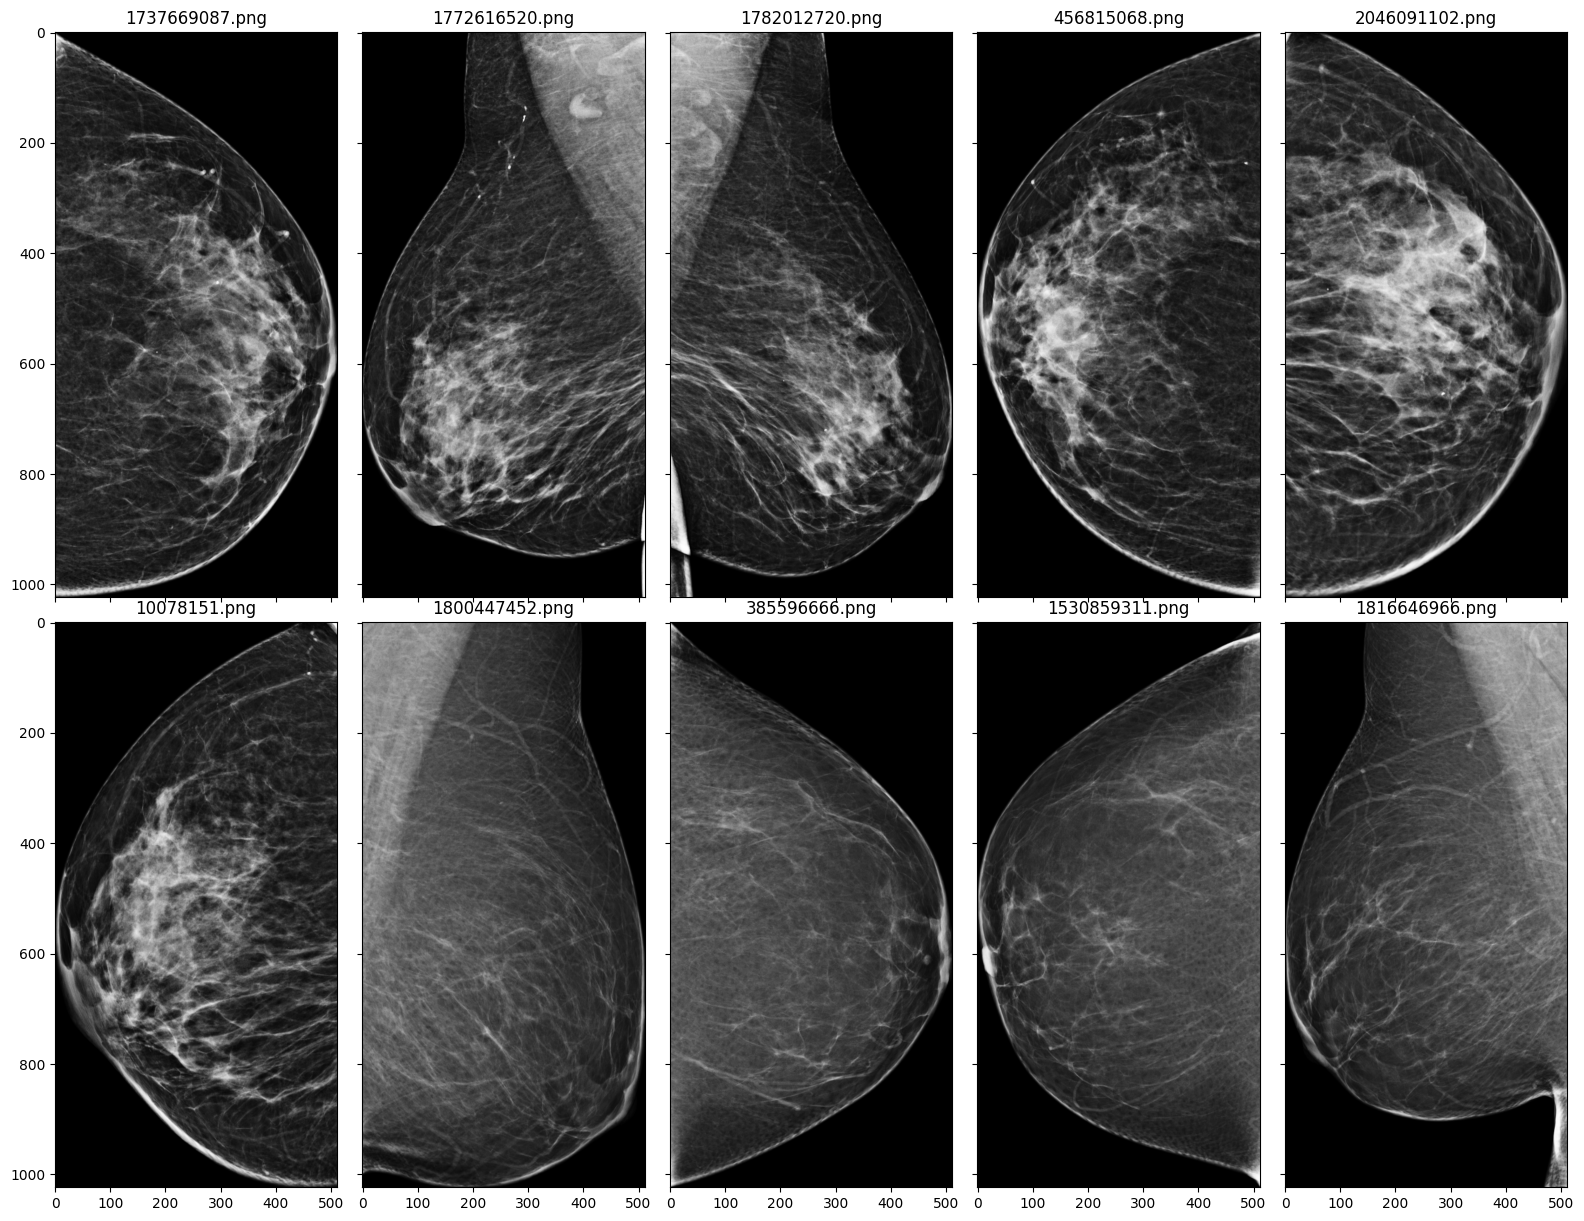

In [23]:
'''
sample_df = train_df.sample(10).reset_index(drop=True)

images = []
titles = []

for i in range(10):
    image = cv2.imread(sample_df['image_path'][i])
    images.append(image)
    titles.append(sample_df['cancer'][i])

plot_images(images, titles)

As we had not loaded all 52K images , so taking random images wont work, so we took the path which are loaded"
'''
image_paths = [
    "/kaggle/working/train_images/11890/1737669087.png",
    "/kaggle/working/train_images/11890/1772616520.png",
    "/kaggle/working/train_images/11890/1782012720.png",
    "/kaggle/working/train_images/11890/456815068.png",
    "/kaggle/working/train_images/11890/2046091102.png",
    "/kaggle/working/train_images/11890/10078151.png",
    "/kaggle/working/train_images/10224/1800447452.png",
    "/kaggle/working/train_images/10224/385596666.png",
    "/kaggle/working/train_images/10224/1530859311.png",
    "/kaggle/working/train_images/10224/1816646966.png",
    "/kaggle/working/train_images/12187/164153679.png",
    "/kaggle/working/train_images/12187/1394862273.png"
]

images = []
titles = []

for image_path in image_paths:
    image = cv2.imread(image_path)
    images.append(image)
    # Extract the filename from the image path
    filename = image_path.split('/')[-1]
    titles.append(filename)

plot_images(images, titles)


In [24]:
!cp /kaggle/input/rsna-breast-cancer-detection/train.csv /kaggle/working/
!cp /kaggle/input/rsna-breast-cancer-detection/test.csv /kaggle/working/
!cp /kaggle/input/rsna-breast-cancer-detection/sample_submission.csv /kaggle/working/